In this series of notebooks, I will attempt to do some introductory exploration of various roller derby statistics. We will use the publicly available stats on the FlatTrackStats website. First, I will build a table scraper tool using the BeautifulSoup4 package to parse the stats tables on the website. If not already installed, you will need pandas and BeautifulSoup4 in order to run this notebook. 

In [2]:
    import requests
    import pandas as pd
    import numpy as np
    from bs4 import BeautifulSoup
    from itertools import product
    import urllib.request
    import urllib.parse
    
    import collections
    import re
    
    #First, define a class to parse HTML tables for bouts and players
    
    class HTMLTableParser:
        def parse_url(self, url):
            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'lxml')
            return [(self.read_table(table)) for table in soup.find_all('table')]      
        
        def read_table(self, table_tag):
            rowspans = []  # track pending rowspans
            rows = table_tag.find_all('tr')

            # first scan, see how many columns we need
            colcount = 0
            column_names=[]
            for r, row in enumerate(rows):
                cells = row.find_all(['td', 'th'], recursive=False)
                colcount = max(
                    colcount,
                    sum(int(c.get('colspan', 1)) or 1 for c in cells[:-1]) + len(cells[-1:]) + len(rowspans))
                # update rowspan bookkeeping; 0 is a span to the bottom. 
                rowspans += [int(c.get('rowspan', 1)) or len(rows) - r for c in cells]
                rowspans = [s - 1 for s in rowspans if s > 1]

            # it doesn't matter if there are still rowspan numbers 'active'; no extra
            # rows to show in the table means the larger than 1 rowspan numbers in the
            # last table row are ignored.    
            # build an empty matrix for all possible cells
            table = [[None] * colcount for row in rows]


            # fill matrix from row data
            rowspans = {}  # track pending rowspans, column number mapping to count
            for row, row_elem in enumerate(rows):
                span_offset = 0  # how many columns are skipped due to row and colspans 
                for col, cell in enumerate(row_elem.find_all(['td', 'th'], recursive=False)):
                    # adjust for preceding row and colspans
                    col += span_offset
                    while rowspans.get(col, 0):
                        span_offset += 1
                        col += 1

                    # fill table data
                    rowspan = rowspans[col] = int(cell.get('rowspan', 1)) or len(rows) - row
                    colspan = int(cell.get('colspan', 1)) or colcount - col
                    # next column is offset by the colspan
                    span_offset += colspan - 1
                    value = cell.get_text()
                    points = len(cell.find_all("div", {"class": " point"}))
                    pens = cell.find_all("div", {"class": "penalty major"})  
                    if (value == '' or value == '&nbsp') and points != '':
                        value = str(points)
                    if len(pens) > 0:
                        value = ''
                        for pen in pens:
                            value += pen.find_all(text=True, recursive=False)[0] + " "
                    if len(cell.find_all("div", {"class": "lead"}))== 1:
                        if value == "0": value = ""
                        value += "Lead "
                    if len(cell.find_all("div", {"class": "leadloss"}))== 1:
                        if value == "0": value = ""
                        value += "LeadLoss "
                    if len(cell.find_all("div", {"class": "lost"}))== 1:
                        if value == "0": value = ""
                        value += "LeadLoss "                   
                    if len(cell.find_all("div", {"class": "call"}))== 1:
                        if value == "0": value = ""
                        value += "call "
                    if len(cell.find_all("div", {"class": "nopass"}))== 1:
                        if value == "0": value = ""
                        value += "np "    
                    if len(cell.find_all("div", {"class": "starpass"}))== 1:
                        if value == "0": value = ""
                        value += "sp "    
                    for drow, dcol in product(range(rowspan), range(colspan)):
                        try:
                            table[row + drow][col + dcol] = value
                            rowspans[col + dcol] = rowspan
                        except IndexError:
                            # rowspan or colspan outside the confines of the table
                            pass

                # update rowspan bookkeeping
                rowspans = {c: s - 1 for c, s in rowspans.items() if s > 1}
            npt = np.array(table)
            #df = pd.DataFrame(np.array(table), column_names) 
            return table

        def parse_url_todf(self, url):
            tables = self.parse_url(url)
            dfs = []
            if "combos" in url:
                for table in tables:
                    headers = table.pop(0)
                    df = pd.DataFrame(np.array(table), columns=np.array(headers))    
                    dfs.append(df)
            if "teams" in url:
                for table in tables:
                    headers = table.pop(0)
                    df = pd.DataFrame(np.array(table), columns=np.array(headers))    
                    dfs.append(df)
            if "jams" in url:
                for table in tables:
                    headers = table.pop(0)
                    df = pd.DataFrame(np.array(table), columns=np.array(headers))    
                    dfs.append(df)        
            else:
                headers = tables[0]
                headersnew = []
                for header in headers:
                    headernew = [i for i in header if i] 
                    headersnew.append(headernew)
                for i in range(len(tables)-1):
                    df = pd.DataFrame(np.array(tables[i+1]), columns=headersnew[i])    
                    dfs.append(df)
                
            return dfs    

Let's make a function to get all of a team's bouts from the database:

In [3]:
def GetAllBouts(teamID):
    npages = 0
    links=[]
    
    base_url = "http://www.flattrackstats.com/teams/"+teamID+"/bouts"
    text = urllib.request.urlopen(base_url)
    base_soup = BeautifulSoup(text)
    
    for listitem in base_soup.findAll('li', class_="pager-last last"):
        npages = int(listitem.findAll('a')[0]['href'][-1])
    
    
    for page in range(0,npages):
        url = "http://www.flattrackstats.com/teams/"+teamID+"/bouts?page="+str(page)
        text = urllib.request.urlopen(url)
        soup = BeautifulSoup(text)
        for link in soup.findAll('a', class_="boutlink has-stats"):
            linkname = link['href']
            linksize = len(linkname)
            if "node" not in link['href']:
                linkstub = linkname[:linksize-8]
            else: linkstub = "/bouts"+linkname[5:]+"/"
            links.append(linkstub)
                
    return links

In [4]:
GetAllBouts(str(3637))

['/bouts/89490/',
 '/bouts/89482/',
 '/bouts/76964/',
 '/bouts/64102/',
 '/bouts/59173/',
 '/bouts/55689/',
 '/bouts/55648/',
 '/bouts/53728/',
 '/bouts/45726/',
 '/bouts/47480/',
 '/bouts/42867/',
 '/bouts/37439/',
 '/bouts/37415/',
 '/bouts/35520/',
 '/bouts/35871/',
 '/bouts/30536/',
 '/bouts/27122/',
 '/bouts/20699/',
 '/bouts/8252/',
 '/bouts/20350/',
 '/bouts/22251/',
 '/bouts/20353/',
 '/bouts/4326/',
 '/bouts/19804/',
 '/bouts/3930/']

Now let's make some functions to read the data from the bouts page (one such page is here: http://flattrackstats.com/bouts/55689/jams).

The first will be a function to read the table of points scored in each jam, logged per lap. This is similar in format to what is recorded on the track. Let's make sure to drop the opposing team's scores from this.

In [5]:
def GetAllScores(teamID, teamName):
    scoreframes = []
    bouts = GetAllBouts(teamID)
    hp = HTMLTableParser()
    for bout in bouts:
        jampage = "http://www.flattrackstats.com/"+bout+"jams"
        
        isAway = False 
        response = requests.get(jampage)
        soup = BeautifulSoup(response.text, 'lxml')
        for link in soup.findAll('title'):
            fulltitle = link.get_text()
            substr = fulltitle[fulltitle.find(':')+1 : fulltitle.find('(')]
            if teamName in substr:
                isAway = True
        
        scores = hp.parse_url_todf(jampage)[1].iloc[:,1:-1]
        scores.loc[np.c_[scores.index[1::2].tolist(),scores.index[0:-1:2].tolist()].reshape(-1)]
        
        #del scores[0]
        #print(scores)
        scoreframes.append(scores)
    allScores = pd.concat(scoreframes)
    #drop opposing team
    allScores = allScores.iloc[::2]
    allScores = allScores.reset_index()
    del allScores['index']
    #print(allScores)
    return(allScores)

Next, let's make a function to get the table recording who played in each jam, and what the cumulative score, jam score, and score differential (my_team - opposing_team) was for that jam. Again, let's drop the opposing team's lineups. This is the function that will give us most of our data!

In [6]:
def GetAllLineups(teamID, teamName):
    lineupframes = []
    bouts = GetAllBouts(teamID)
    hp = HTMLTableParser()
    for bout in bouts:
        jampage = "http://www.flattrackstats.com/"+bout+"jams"
        
        isAway = False 
        response = requests.get(jampage)
        soup = BeautifulSoup(response.text, 'lxml')
        for link in soup.findAll('title'):
            fulltitle = link.get_text()
            substr = fulltitle[fulltitle.find(':')+1 : fulltitle.find('(')]
            if teamName in substr:
                isAway = True        
        lineups = hp.parse_url_todf(jampage)[2].iloc[:,1:-1]
        
        #put team of interest first (data is naturally in format (home, away) )
        if isAway:
            lineups = lineups.loc[np.c_[lineups.index[1::2].tolist(),lineups.index[0:-1:2].tolist()].reshape(-1)]
        lineupframes.append(lineups) 
        
    #clean data    
    allLineups = pd.concat(lineupframes)
    allLineups.columns = ['Jammer','Jstats','B1','B2','B3','B4','NULL','jamscore','runscore']
    del allLineups['NULL']
    
    allLineups = allLineups[~(allLineups.jamscore == 'Period 2')]
    allLineups = allLineups[~(allLineups.jamscore.isnull())]
    
    #calc score differentials, for determining rankings
    allLineups['jamscore'] = pd.to_numeric(allLineups['jamscore'])
    allLineups['runscore'] = pd.to_numeric(allLineups['runscore'])
    
    allLineups['ScoreDiff'] = allLineups['jamscore'].diff(periods=-1)
    
    #drop opposing team
    allLineups = allLineups.iloc[::2]
    allLineups = allLineups.reset_index()
    del allLineups['index']
    
    return(allLineups)

Next, let's make a function to get the penalties per jam. This will need to be cross-referenced with the lineups table in order to determine who got what penalties.

In [7]:
def GetAllPenalties(teamID, teamName):
    penframes = []
    bouts = GetAllBouts(teamID)
    hp = HTMLTableParser()
    for bout in bouts:
        jampage = "http://www.flattrackstats.com/"+bout+"jams"
        
        isAway = False 
        response = requests.get(jampage)
        soup = BeautifulSoup(response.text, 'lxml')
        for link in soup.findAll('title'):
            fulltitle = link.get_text()
            substr = fulltitle[fulltitle.find(':')+1 : fulltitle.find('(')]
            if teamName in substr:
                isAway = True
        
        pens = hp.parse_url_todf(jampage)[3].iloc[:,1:-1]
        
        if isAway:
            pens.loc[np.c_[pens.index[1::2].tolist(),pens.index[0:-1:2].tolist()].reshape(-1)]

        #del pens[0]
        penframes.append(scores)
    allPens = pd.concat(penframes)
    #print(allPens)
    return(allPens)

In lieu of rankings like ELO, let's just use an average of the score differential for each blocker (something like ELO would be better, but cumbersome to caclulate right now). Let's get an expanding average of the blocker's point differential (that is, after a given jam, the point differential for each jam the blocker has played in, averaged over all the times they have played).

After calculating the expanding averages, let's also drop all jams for which one or more blockers involved hasn't played in at least 12 jams (that is, roughly one half a bout) from the dataset. This gives each blocker's average score differential a chance to stabilize. This block also has some other functions that might be useful for calculating the useful metrics for each jam.

In [9]:
def ExpandingAverages(teamID, teamName):
    lineups = GetAllLineups(teamID,teamName)
    allBlockers = (lineups['B1'].append(lineups['B2']).append(lineups['B3']).append(lineups['B4'])).unique()
    #print(allBlockers, len(allBlockers))
    blockerCols = lineups[['B1','B2','B3','B4']]
    #print(blockerCols)
    blockerlist = pd.concat([pd.get_dummies(blockerCols[col]) for col in blockerCols.columns], axis = 1)
    indicators = blockerlist.groupby(by=blockerlist.columns, axis=1).sum()
    scorediffs = indicators.mul(lineups['ScoreDiff'], axis=0)
    #don't include unplayed jams
    scorediffs.replace(0, np.nan, inplace=True)
    runningmean = scorediffs.expanding(1).mean()
    runningmean.replace(np.nan, 0, inplace=True)
    pd.set_option('display.max_columns', 58)  # or 1000
    pd.set_option('display.max_rows', 20)  # or 1000
    pd.set_option('display.max_colwidth', 15)  # or 199
    #test2 = pd.concat([pd.get_dummies(blockerCols[col]) for col in blockerCols.columns], axis=1)
    #test = lineups.stack().str.get_dummies(columns =['B1','B2','B3','B4']).sum(level=0)
    return(runningmean)

In [ ]:
# This function just gets a player's running score differential (i.e., if a player scores +1 and then -1, after those two jams,
# it returns zero)

def RunningDiffs(teamID, teamName):
    lineups = GetAllLineups(teamID,teamName)
    allBlockers = (lineups['B1'].append(lineups['B2']).append(lineups['B3']).append(lineups['B4'])).unique()
    #print(allBlockers, len(allBlockers))
    blockerCols = lineups[['B1','B2','B3','B4']]
    #print(blockerCols)
    blockerlist = pd.concat([pd.get_dummies(blockerCols[col]) for col in blockerCols.columns], axis = 1)
    indicators = blockerlist.groupby(by=blockerlist.columns, axis=1).sum()
    scorediffs = indicators.mul(lineups['ScoreDiff'], axis=0)
    scorediffs.replace(0, np.nan, inplace=True)
    pd.set_option('display.max_columns', 58)  # or 1000
    pd.set_option('display.max_rows', 20)  # or 1000
    pd.set_option('display.max_colwidth', 15)  # or 199
    #test2 = pd.concat([pd.get_dummies(blockerCols[col]) for col in blockerCols.columns], axis=1)
    #test = lineups.stack().str.get_dummies(columns =['B1','B2','B3','B4']).sum(level=0)
    return(scorediffs)

In [10]:
#This function returns a running list of how much a given jam changes a player's average

def AvgChangeFromJam(teamID, teamName):
    avgs = ExpandingAverages(teamID, teamName)
    avgswzero = pd.DataFrame([[0.0] * len(avgs.columns)], columns=avgs.columns)
    avgs = avgswzero.append(avgs, ignore_index=True)
    deltas = avgs.diff()
    deltas = deltas.drop([0])
    return deltas

In [11]:
#This function returns a list of how many total jams a player has played at a particular time

def JamsPlayed(teamID, teamName):
    lineups = GetAllLineups(teamID,teamName)
    allBlockers = (lineups['B1'].append(lineups['B2']).append(lineups['B3']).append(lineups['B4'])).unique()
    #print(allBlockers, len(allBlockers))
    blockerCols = lineups[['B1','B2','B3','B4']]
    #print(blockerCols)
    blockerlist = pd.concat([pd.get_dummies(blockerCols[col]) for col in blockerCols.columns], axis = 1)
    indicators = blockerlist.groupby(by=blockerlist.columns, axis=1).sum()
    indicators.replace(0, np.nan, inplace=True)
    jamtot = indicators.expanding(1).sum()
    return(jamtot)

In [12]:
#This function returns a list of all jams for which any player involved has not played N jams,
#as well as a list of blockers who play a total of fewer than N jams.

def GetBadJamsAndBlockers(teamID, teamName, N=12):
    lineups = GetAllLineups(teamID,teamName)
    jp = JamsPlayed(teamID,teamName)
    allBlockers = (lineups['B1'].append(lineups['B2']).append(lineups['B3']).append(lineups['B4'])).unique()
    #print(allBlockers, len(allBlockers))
    blockerCols = lineups[['B1','B2','B3','B4']]
    #print(blockerCols)
    badjamlist = []
    
    for jamnum in range(len(jp)):
        for col in blockerCols.columns:
            blockername = blockerCols.loc[jamnum,col]
            jamcount = jp.loc[jamnum,blockername]
            if (jamcount < N): 
                badjamlist.append(jamnum)
    
    mask = jp.iloc[-1] < N
    badjp = jp.loc[:, mask]
    badblockerlist=list(badjp.columns)
    
    badjamarray = np.array(badjamlist)
    badjamarray=np.unique(badjamarray)
    
    return(badjamarray.tolist(),badblockerlist)

Now that we've got all our functions, let's do some preprocessing. First, we want to make sure that the ExpandingAverage is a relatively stable metric of a player's skill, and determine approximately the number of jams played that is needed for the metric to be valid. Let's look at Gotham, one of the better-statted-out teams in the league.

In [19]:
#Remove bad jams and blockers

def ExpandingAveragesCleaned(teamID, teamName,N=12):
    avgs = ExpandingAverages(teamID, teamName)
    badjams,badblockers = GetBadJamsAndBlockers(teamID, teamName,N)
    avgs= avgs.drop(labels=badjams, axis=0)
    avgs= avgs.drop(labels=badblockers, axis=1)
    
    return(avgs)

In [20]:
exa12= ExpandingAveragesCleaned(str(3637),'Killamazoo',12)
exa12

,Afterburner,Aly-Kate Contusion...,Anita Tuf Moth'r,Badass Maggie,Beaver Jam,Belles,Beverly Hells,Bicked Witch,Buns N Roses,Charisnakov,Crashive Aggressiv...,Delilah Danger,Doobie Trap,Emma Pistol,Goin Commando,Heartless Hottie,Hill-De-Beast,Jane Deere,Javelin,Jessie Girl,Killamity Cate,Lady Hawk,Lily St. Smear,Maggie Walters,Mea Chokeavich,Merica,Miss B. Haven (KDD...,Miss Bea Haven (PO...,Mustang,Neva,Noam Stompsky,Ophelia Plenty,Painbow Connection,Protasiewicz,Ramona D. Flowers ...,RocKickAss,Rocket HIps,Rolla Ramher,Rosie Ferocious,Smash Bandicute,Smash UrAsh,Sparkills (KDD),Spicy Jalapeno,Stinker Belle,Terrorhawk,The Heckler,Wreck Keene Ball,Yoga Nagettit
32,0.000000,-5.266667,0.000000,0.000000,0.500000,0.000000,-14.222222,0.000000,-6.285714,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,-4.200000,0.000000,0.000000,0.000000,0.000000,-9.090909,-6.000000,0.0000,0.000000,0.000000,-6.125000,0.000000,0.000000,-10.090909,-10.083333,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-11.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-5.461538,0.000000
38,0.000000,-5.187500,0.000000,0.000000,0.500000,0.000000,-15.500000,0.000000,-5.111111,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,-4.941176,0.000000,0.000000,0.000000,0.000000,-8.571429,-5.909091,0.0000,0.000000,0.000000,-7.900000,0.000000,0.000000,-8.357143,-10.600000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-10.375000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-4.750000,0.000000
40,0.000000,-5.470588,0.000000,0.000000,0.500000,0.000000,-15.500000,0.000000,-5.111111,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,-5.684211,0.000000,0.000000,0.000000,0.000000,-8.666667,-6.583333,0.0000,0.000000,0.000000,-7.900000,0.000000,0.000000,-8.357143,-10.600000,-14.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-10.352941,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-5.294118,0.000000
43,0.000000,-4.888889,0.000000,0.000000,0.500000,0.000000,-13.636364,0.000000,-5.111111,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,-5.600000,0.000000,0.000000,0.000000,0.000000,-7.588235,-6.214286,0.0000,0.000000,0.000000,-7.545455,0.000000,0.000000,-7.466667,-10.600000,-9.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-10.352941,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-5.157895,0.000000
44,0.000000,-4.421053,0.000000,0.000000,0.500000,0.000000,-13.636364,0.000000,-5.111111,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,-5.600000,0.000000,0.000000,0.000000,0.000000,-7.588235,-5.533333,0.0000,0.000000,0.000000,-7.545455,0.000000,0.000000,-7.466667,-10.600000,-9.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-9.555556,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-4.700000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,-9.888889,0.921875,0.545455,0.522727,-2.181818,-4.409091,-7.312500,4.818182,-5.230769,-0.9375,-1.022727,-4.666667,5.266667,-1.480519,1.109589,0.336207,-4.904762,0.430769,0.105911,2.860465,0.658228,-4.166667,0.319620,-7.166667,-2.093750,-5.8125,1.078431,-1.157895,-3.190476,1.381974,-3.947368,-6.183673,-10.600000,-4.592593,2.202381,-1.212121,-8.133333,-0.73913,-1.553571,-5.694444,0.653846,0.428571,-2.0,-2.035714,-1.233129,-1.3,-2.214286,-2.230769
1059,-9.888889,0.921875,0.545455,0.522727,-2.181818,-4.409091,-7.312500,4.818182,-5.230769,-0.9375,-1.022727,-4.900000,5.266667,-1.480519,1.109589,0.336207,-4.904762,0.430769,0.105911,2.860465,0.556250,-3.714286,0.274448,-7.166667,-2.093750,-5.8125,1.078431,-1.157895,-3.190476,1.381974,-3.947368,-6.183673,-10.600000,-4.592593,2.202381,-1.212121,-8.133333,-0.73913,-1.553571,-5.694444,0.653846,0.400000,-2.0,-2.035714,-1.233129,-1.3,-2.214286,-2.200000
1061,-9.888889,0.896373,0.545455,0.522727,-2.181

In [31]:
exa20= ExpandingAveragesCleaned(str(3637),'Killamazoo',20)
exa20

,Aly-Kate Contusion...,Anita Tuf Moth'r,Badass Maggie,Beaver Jam,Belles,Beverly Hells,Buns N Roses,Charisnakov,Crashive Aggressiv...,Delilah Danger,Emma Pistol,Goin Commando,Heartless Hottie,Hill-De-Beast,Jane Deere,Javelin,Jessie Girl,Killamity Cate,Lily St. Smear,Maggie Walters,Mea Chokeavich,Merica,Miss B. Haven (KDD...,Miss Bea Haven (PO...,Mustang,Neva,Noam Stompsky,Ophelia Plenty,Protasiewicz,Ramona D. Flowers ...,RocKickAss,Rolla Ramher,Rosie Ferocious,Smash Bandicute,Smash UrAsh,Sparkills (KDD),Spicy Jalapeno,Stinker Belle,Terrorhawk,The Heckler,Wreck Keene Ball,Yoga Nagettit
61,-4.269231,0.000000,0.000000,0.500000,0.000000,-11.055556,-5.111111,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,-4.103448,0.000000,0.000000,0.000000,-6.538462,-3.952381,0.0000,0.000000,0.000000,-3.333333,0.000000,0.000000,-5.954545,0.625000,0.000000,0.000000,0.00000,0.000000,-7.423077,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-3.750000,0.000000
63,-3.962963,0.000000,0.000000,0.500000,0.000000,-9.842105,-5.111111,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,-3.833333,0.000000,0.000000,0.000000,-5.851852,-3.952381,0.0000,0.000000,0.000000,-3.333333,0.000000,0.000000,-4.791667,0.625000,0.000000,0.000000,0.00000,0.000000,-6.703704,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-3.440000,0.000000
65,-3.586207,0.000000,0.000000,0.500000,0.000000,-9.842105,-5.111111,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,-3.500000,0.000000,0.000000,0.000000,-5.851852,-3.727273,0.0000,0.000000,0.000000,-3.333333,0.000000,0.000000,-4.560000,0.777778,0.000000,0.000000,0.00000,0.000000,-6.703704,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-3.230769,0.000000
66,-3.600000,0.000000,0.000000,0.500000,0.000000,-9.842105,-5.111111,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,-3.500000,0.000000,0.000000,0.000000,-5.785714,-3.739130,0.0000,0.000000,0.000000,-3.333333,0.000000,0.000000,-4.560000,0.777778,0.000000,0.000000,0.00000,0.000000,-6.607143,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-3.230769,0.000000
67,-3.354839,0.000000,0.000000,0.500000,0.000000,-9.842105,-5.111111,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,-3.272727,0.000000,0.000000,0.000000,-5.785714,-3.739130,0.0000,0.000000,0.000000,-3.333333,0.000000,0.000000,-4.230769,0.777778,0.000000,0.000000,0.00000,0.000000,-6.607143,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-2.962963,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,0.952880,0.545455,0.522727,-2.181818,-4.409091,-7.361702,-5.230769,-0.9375,-1.022727,-4.666667,-1.480519,1.109589,0.336207,-4.904762,0.430769,0.141089,2.860465,0.658228,0.319620,-7.166667,-2.093750,-5.8125,1.078431,-1.157895,-3.190476,1.381974,-3.947368,-6.183673,-4.592593,2.245509,-1.212121,-0.73913,-1.418182,-5.694444,0.653846,0.428571,-2.0,-2.035714,-1.233129,-1.3,-2.214286,-2.052632
1057,0.921875,0.545455,0.522727,-2.181818,-4.409091,-7.312500,-5.230769,-0.9375,-1.022727,-4.666667,-1.480519,1.109589,0.336207,-4.904762,0.430769,0.105911,2.860465,0.658228,0.319620,-7.166667,-2.093750,-5.8125,1.078431,-1.157895,-3.190476,1.381974,-3.947368,-6.183673,-4.592593,2.202381,-1.212121,-0.73913,-1.553571,-5.694444,0.653846,0.428571,-2.0,-2.035714,-1.233129,-1.3,-2.214286,-2.230769
1061,0.896373,0.545455,0.522727,-2.181818,-4.409091,-7.244898,-5.230769,-0.9375,-1.022727,-4.560976,-1.480519,1.109589,0.336207,-4.904762,0.430769,0.105911,2.860465,0.580247,0.301887,-7.166667,-2.093750,-5.8125,1.078431,-1.157895,-3.190476,1.381974,-3.615385,-6.183673,-4.592593,2.202381,-1.212121,-0.73913,-1.553571,-5.694444,0.653846,0.400000,-2.0,-2.035714,-1.233129,-1.3,-2.214286,-2.200000
1063,0.896373,0.545455,0.522727,-2.181818,-4.409091,-7.244898,-5.230769,-0.9375,-1.022727,-4.560976,-1.480519,1.109589,0.336207,-4.904762,0.430769,0.105911,2.860465,0

In [32]:
exa30= ExpandingAveragesCleaned(str(3637),'Killamazoo',30)
exa30

,Aly-Kate Contusion...,Badass Maggie,Beverly Hells,Buns N Roses,Charisnakov,Crashive Aggressiv...,Delilah Danger,Emma Pistol,Goin Commando,Heartless Hottie,Jane Deere,Javelin,Jessie Girl,Killamity Cate,Lily St. Smear,Maggie Walters,Mea Chokeavich,Merica,Miss B. Haven (KDD...,Neva,Noam Stompsky,Ophelia Plenty,Protasiewicz,Ramona D. Flowers ...,RocKickAss,Rolla Ramher,Rosie Ferocious,Smash Bandicute,Smash UrAsh,Sparkills (KDD),Stinker Belle,Terrorhawk,Yoga Nagettit
229,-2.784314,0.000000,-9.631579,-5.230769,0.0000,-1.852941,0.000000,-3.742857,0.000000,2.888889,0.000000,-3.488636,-1.100000,0.000000,-3.000000,-7.166667,-2.09375,-7.060606,2.375000,-3.000000,0.000000,-6.183673,-4.592593,0.000000,0.000000,-2.195652,0.000000,-5.694444,0.000000,0.000000,-8.363636,0.000000,0.000000
233,-2.784314,0.000000,-9.631579,-5.230769,0.0000,-1.714286,0.000000,-3.135135,0.000000,3.727273,0.000000,-3.366667,-1.100000,0.000000,-2.772727,-7.166667,-2.09375,-6.705882,3.222222,-2.677419,0.000000,-6.183673,-4.592593,0.000000,0.000000,-1.791667,0.000000,-5.694444,0.000000,0.000000,-8.363636,0.000000,0.000000
237,-2.784314,0.000000,-9.631579,-5.230769,0.0000,-1.777778,0.000000,-3.210526,0.000000,3.692308,0.000000,-3.293478,-1.100000,0.000000,-2.800000,-7.166667,-2.09375,-6.416667,2.363636,-2.515152,0.000000,-6.183673,-4.592593,0.000000,0.000000,-1.780000,0.000000,-5.694444,0.000000,0.000000,-8.363636,0.000000,0.000000
245,-2.784314,0.000000,-9.631579,-5.230769,0.0000,-2.131579,0.000000,-2.775000,0.000000,1.647059,0.000000,-3.347368,-0.571429,0.000000,-3.063830,-7.166667,-2.09375,-6.416667,0.333333,-2.861111,0.000000,-6.183673,-4.592593,0.000000,0.000000,-1.777778,0.000000,-5.694444,0.000000,0.000000,-8.363636,0.000000,0.000000
253,-2.784314,0.000000,-9.631579,-5.230769,0.0000,-1.825000,0.000000,-2.386364,0.000000,1.090909,0.000000,-3.360825,-0.571429,0.000000,-2.916667,-7.166667,-2.09375,-6.282051,1.000000,-2.743590,0.000000,-6.183673,-4.592593,0.000000,0.000000,-1.551724,0.000000,-5.694444,0.000000,0.000000,-8.363636,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,0.952880,0.522727,-7.361702,-5.230769,-0.9375,-1.022727,-4.666667,-1.480519,1.109589,0.336207,0.430769,0.141089,2.860465,0.658228,0.319620,-7.166667,-2.09375,-5.812500,1.078431,1.381974,-3.947368,-6.183673,-4.592593,2.245509,-1.212121,-0.739130,-1.418182,-5.694444,0.653846,0.428571,-2.035714,-1.233129,-2.052632
1057,0.921875,0.522727,-7.312500,-5.230769,-0.9375,-1.022727,-4.666667,-1.480519,1.109589,0.336207,0.430769,0.105911,2.860465,0.658228,0.319620,-7.166667,-2.09375,-5.812500,1.078431,1.381974,-3.947368,-6.183673,-4.592593,2.202381,-1.212121,-0.739130,-1.553571,-5.694444,0.653846,0.428571,-2.035714,-1.233129,-2.230769
1061,0.896373,0.522727,-7.244898,-5.230769,-0.9375,-1.022727,-4.560976,-1.480519,1.109589,0.336207,0.430769,0.105911,2.860465,0.580247,0.301887,-7.166667,-2.09375,-5.812500,1.078431,1.381974,-3.615385,-6.183673,-4.592593,2.202381,-1.212121,-0.739130,-1.553571,-5.694444,0.653846,0.400000,-2.035714,-1.233129,-2.200000
1063,0.896373,0.522727,-7.244898,-5.230769,-0.9375,-1.022727,-4.560976,-1.480519,1.109589,0.336207,0.430769,0.105911,2.860465,0.580247,0.301887,-7.166667,-2.09375,-5.812500,1.078431,1.381974,-4.025000,-6.183673,-4.592593,2.202381,-1.212121,-0.739130,-1.877193,-5.694444,0.653846,0.400000,-2.035714,-1.233129,-2.634146


Ok, let's use 12 as our minimum number of jams and plot the expanding averages for Javelin, one of Kalamazoo's longest-playing blockers.

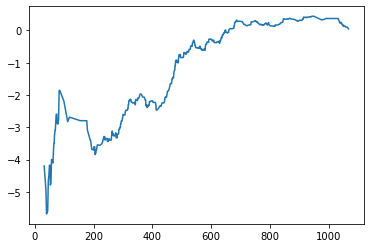

In [47]:
exa12["Javelin"].plot()

Okay great! This seems to be pretty good- we can see her steadily improving over time, starting out circa -5 and getting to a differential of zero. This is a solid metric. If we wanted to, we could compare this to ELO and other ranking systems to determine accuracy- how predictive the various metrics are- 